In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator , TransformerMixin
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import GridSearchCV, cross_val_score , cross_val_predict , cross_validate,train_test_split,StratifiedKFold,ShuffleSplit
from sklearn.metrics import classification_report , classification,accuracy_score ,roc_auc_score

In [2]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [3]:
from sklearn.datasets import load_iris, make_moons

In [4]:
%matplotlib inline

In [4]:
data,target= load_iris()['data'][:, 2:], load_iris()['target']
target_names, feature_names =  load_iris()['target_names'] , load_iris()['feature_names']

In [11]:
pd.Series(target).value_counts()

2    50
1    50
0    50
dtype: int64

In [6]:
dt = DecisionTreeClassifier(max_depth= 2)
model_tree = dt.fit(data, target)

In [7]:
def plot_data(x, y): 
    plt.plot(x[:, 0][y == 0], x[:,1][y == 0], 'bs')
    plt.plot(x[:, 0][y == 1], x[:,1][y == 1], 'g^')
    plt.plot(x[:, 0][y == 2], x[:,1][y == 2], 'r.')
    plt.axis([x[:, 0].min(),x[:, 0].max(),x[:, 1].min(),x[:, 1].max()])
    plt.grid(True)
    plt.xlabel(r'$X1$' , fontsize = 15)
    plt.ylabel(r'$Y1$', fontsize = 15, rotation = 0)

In [8]:
def plot_density_fun(x, y , model):
    h = 0.02 #stepsize in mesh 
    x0 = np.arange(x[:, 0].min() - 0.5, x[:, 0].max() + 0.5 , 0.2)
    x1 = np.arange(x[: , 1].min() - 0.5, x[:, 1].max() + 0.5 , 0.2) 
    xx, yy = np.meshgrid(x0, x1)
    X = np.c_[xx.ravel(), yy.ravel()]
    y_pred = model.predict(X).ravel().reshape(xx.shape)
    #y_decision_fun = model.decision_function(X).ravel().reshape(xx.shape)
    plt.contourf(xx, yy , y_pred)
    #plt.contourf(xx,yy, y_decision_fun)

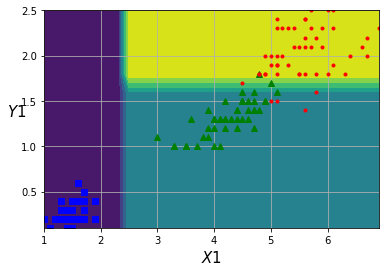

In [9]:
plot_density_fun(data,target, model_tree)
plot_data(data,target)

In [10]:
export_graphviz(
        model_tree
     ,feature_names = feature_names[2:]
     ,class_names = target_names
     ,rounded = True
     , filled = True
    ,out_file = 'iris_tree.dot'
               )

# Exercise

In [11]:
data, target = make_moons(n_samples= 10000, noise= 0.4)

In [12]:
x_train , x_test, y_train, y_test = train_test_split(data, target , test_size = 0.3, random_state = 42)

In [13]:
DT = DecisionTreeClassifier(random_state= 42)

In [14]:
para = {'max_depth': [2,3,4] 
       ,'min_samples_leaf':[2,5,7]
        ,'criterion':['gini', 'entropy']
        ,'max_leaf_nodes': [3,5,7,10]
       }
grid = GridSearchCV(DT,param_grid= para,cv= 3)
grid.fit(x_train,y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4], 'min_samples_leaf': [2, 5, 7], 'criterion': ['gini', 'entropy'], 'max_leaf_nodes': [3, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [15]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_leaf_nodes': 10,
 'min_samples_leaf': 2}

In [16]:
DT_best = DecisionTreeClassifier(random_state= 42 ,criterion= 'gini', max_depth= 2, max_leaf_nodes= 5 , min_samples_leaf= 2 )
DT_best.fit(x_train, y_train)
y_pred = DT_best.predict(x_test)

In [17]:
print(classification_report(y_test, y_pred)) 

             precision    recall  f1-score   support

          0       0.84      0.87      0.85      1490
          1       0.86      0.83      0.85      1510

avg / total       0.85      0.85      0.85      3000



In [18]:
accuracy_score(y_test, y_pred)

0.8496666666666667

# Excersice 2 

In [22]:
from sklearn.base import clone

In [58]:
n_trees = 1000
instances = 100 
sf = ShuffleSplit(n_splits= n_trees , test_size= len(x_train)- 100 , random_state= 42)
mini_splits = []
for train_index, test_index in sf.split(x_train):
    mini_splits.append((x_train[train_index], y_train[train_index]))

In [56]:
forest = [clone(grid.best_estimator_) for _ in range(n_trees)]

In [62]:
score = []
for tree, (x_train_mini, y_train_mini) in zip(forest, mini_splits):
    tree.fit(x_train_mini, y_train_mini)
    y_pred = tree.predict(x_test)
    score.append(accuracy_score(y_test, y_pred)) 
np.mean(score)

0.7995140000000001

Random Forest 

In [72]:
y_pred_rf = np.empty([n_trees, len(x_test)], dtype = np.uint8)
for index,tree in enumerate(forest):
    y_pred_rf[index] = tree.predict(x_test)


In [89]:
from scipy.stats import mode

y_pred_rf_result, count = mode(y_pred_rf,axis = 0)
accuracy_score(y_test, y_pred_rf_result.reshape(-1))

0.856